In [73]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM
from transformers import BertModel, AlbertModel, DistilBertModel, RobertaModel, OpenAIGPTModel, GPT2Model

In [74]:
def rankscore(d,h,dh,Wq,Wk):

    RankFull = np.linalg.matrix_rank(Wq @ Wk)
    RankHeads = []

    for j, head in enumerate(range(0, d, dh)):
        M = Wq[:, head: head + dh] @ Wk[head : head + dh,:]
        RankHeads.append(np.linalg.matrix_rank(M))

    print(RankFull)
    print(np.sum(RankHeads) - RankFull)
    
    return  RankFull, RankHeads

In [75]:
def getscoresBERT(d,l,h,dh,model):

    RankFullList = np.zeros(l)
    RankHeadsList = np.zeros((l,h))
    for layer in range(l):
        
        Wq = model.encoder.layer[layer].attention.self.query.weight.detach().numpy()
        Wk = model.encoder.layer[layer].attention.self.key.weight.detach().numpy()

        RankFull, RankHeads = rankscore(d,h,dh,Wq.T,Wk)
        RankFullList[layer] = RankFull
        RankHeadsList[layer,:] = RankHeads

    return  RankFullList, RankHeadsList

def getscoresALBERT(d,l,h,dh,model):

    RankFullList = np.zeros(l)
    RankHeadsList = np.zeros((l,h))
    for layer in range(l):
        
        Wq = model.encoder.albert_layer_groups[layer].albert_layers[0].attention.query.weight.detach().numpy()
        Wk = model.encoder.albert_layer_groups[layer].albert_layers[0].attention.key.weight.detach().numpy()

        RankFull, RankHeads = rankscore(d,h,dh,Wq.T,Wk)
        RankFullList[layer] = RankFull
        RankHeadsList[layer,:] = RankHeads

    return  RankFullList, RankHeadsList

def getscoresGPT(d,l,h,dh,model):

    RankFullList = np.zeros(l)
    RankHeadsList = np.zeros((l,h))
    for layer in range(l):
        
        Wq = model.h[layer].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.h[layer].attn.c_attn.weight[:,d:2*d].detach().numpy()

        RankFull, RankHeads = rankscore(d,h,dh,Wq.T,Wk)
        RankFullList[layer] = RankFull
        RankHeadsList[layer,:] = RankHeads

    return  RankFullList, RankHeadsList

In [76]:
dh = 64
l = 2
d = 128
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

RankFull, RankHeads = getscoresBERT(d,l,h,dh,model)

128
0
121
7


In [69]:
RankFull

array([128., 123.])

In [70]:
l = 12
d = 768
h = d // dh
model = BertModel.from_pretrained("bert-base-uncased")

RankFull, RankHeads = getscoresBERT(d,l,h,dh,model)

746
22
746
22
733
35
749
19


KeyboardInterrupt: 

In [65]:
RankHeads

array([[64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.],
       [64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.]])

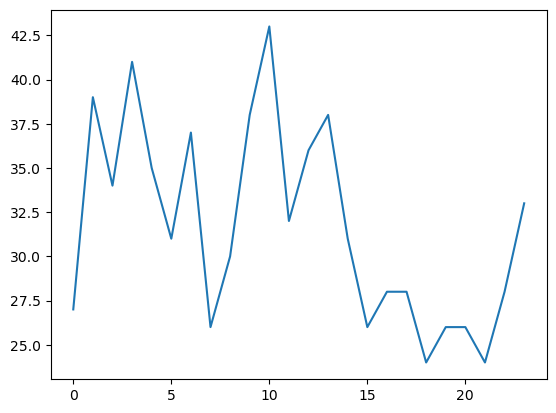

In [48]:
plt.plot((RankHeads.sum(axis=1) - RankFull))

In [50]:
l = 1
d = 768
h = d // dh
model = AlbertModel.from_pretrained("albert-base-v2")
RankFull, RankHeads = getscoresALBERT(d,l,h,dh,model)

707
61


In [53]:
'GPT 1 (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = OpenAIGPTModel.from_pretrained("openai-gpt")
RankFull, RankHeads = getscoresGPT(d,l,h,dh,model)

504
264
754
14
753
15
750
18
744
24
746
22
745
23
748
20
748
20
748
20
755
13
754
14


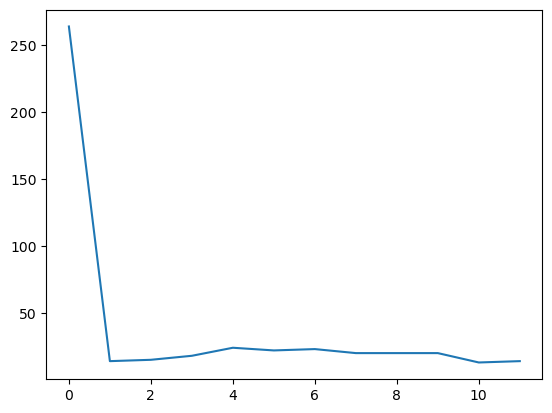

In [54]:
plt.plot((RankHeads.sum(axis=1) - RankFull))

In [55]:
l = 12
d = 768
h = d // dh
model = GPT2Model.from_pretrained('gpt2')
RankFull, RankHeads = getscoresGPT(d,l,h,dh,model)

742
26
724
44
729
39
741
27
742
26
741
27
741
27
742
26
742
26
746
22
748
20
746
22


In [56]:
l = 48
d = 1600
h = d // dh
model = GPT2Model.from_pretrained('gpt2-xl')
RankFull, RankHeads = getscoresGPT(d,l,h,dh,model)

1318
282
1491
109
1472
128
1491
109
1520
80
1535
65
1532
68
1533
67
1542
58
1544
56
1546
54
1539
61
1533
67
1535
65
1521
79
1536
64
1539
61
1524
76
1518
82
1526
74
1548
52
1543
57
1545
55
1550
50
1551
49
1549
51
1551
49
1553
47
1551
49
1555
45
1553
47
1553
47


KeyboardInterrupt: 